# Estudo de caso: Previsão do tempo (Inmet)

- Download dos dados no Inmet
- Prevendo a temperatura máxima diária para 14 dias sem variáveis exôgeneas
- Prevendo a temperatura máxima diária para 14 dias com variáveis exôgeneas

In [1]:
import warnings


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import (
    explained_variance_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
)
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import ForecastingPipeline  # exo
from sktime.forecasting.compose import TransformedTargetForecaster, make_reduction
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import (
    ForecastingRandomizedSearchCV,
    SingleWindowSplitter,
    temporal_train_test_split,
)
from sktime.pipeline import make_pipeline  # endo
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

warnings.filterwarnings("ignore")


def load_data():
    df1 = pd.read_csv("../datasets/inmet/A435_20220301_20220831.csv", sep=";")
    df2 = pd.read_csv("../datasets/inmet/A435_20220901_20230131.csv", sep=";")
    df3 = pd.read_csv("../datasets/inmet/A435_20230201_20230630.csv", sep=";")
    df = pd.concat([df1, df2, df3], axis=0)
    df.columns = [
        "Data",
        "Hora_UTC",
        "Temp_Ins_C",
        "Temp_Max_C",
        "Temp_Min_C",
        "Umi_Ins_percent",
        "Umi_Max_percent",
        "Umi_Min_percent",
        "Pto_Orvalho_Ins_C",
        "Pto_Orvalho_Max_C",
        "Pto_Orvalho_Min_C",
        "Pressao_Ins_hPa",
        "Pressao_Max_hPa",
        "Pressao_Min_hPa",
        "Vel_Vento_m_por_s",
        "Dir_Vento_m_por_s",
        "Raj_Vento_m_por_s",
        "Radiacao_KJ_por_m2",
        "Chuva_mm",
    ]
    for col in df.columns[2:]:
        df[col] = df[col].map(lambda x: float(str(x).replace(",", ".")))
    df = df.groupby("Data").agg(
        {
            "Temp_Ins_C": "mean",
            "Temp_Max_C": "max",
            "Temp_Min_C": "min",
            "Umi_Ins_percent": "mean",
            "Umi_Max_percent": "max",
            "Umi_Min_percent": "min",
            "Pto_Orvalho_Ins_C": "mean",
            "Pto_Orvalho_Max_C": "max",
            "Pto_Orvalho_Min_C": "min",
            "Pressao_Ins_hPa": "mean",
            "Pressao_Max_hPa": "max",
            "Pressao_Min_hPa": "min",
            "Vel_Vento_m_por_s": "mean",
            "Dir_Vento_m_por_s": "mean",
            "Raj_Vento_m_por_s": "mean",
            "Radiacao_KJ_por_m2": "mean",
            "Chuva_mm": "sum",
        }
    )
    return df.reset_index()


def preprocessing_date(
    data: pd.DataFrame, period: str, date_column_name: str = "Date"
) -> pd.DataFrame:
    """Return data with Date feature in index.

    Args:
        data (pd.DataFrame): Data with a "Date" column
        period (str): "D", "M", "Y"
        date_column_name (str): Default is "Date"
    """
    data_copy = data.copy()
    data_copy[date_column_name] = pd.to_datetime(
        data_copy[date_column_name], dayfirst=True
    )
    data_copy[date_column_name] = data_copy[
        date_column_name].dt.to_period(period)
    data_copy.set_index(date_column_name, inplace=True)
    data_copy = data_copy.sort_index()
    return data_copy


def compute_errors(y_test: pd.Series, y_pred: pd.Series) -> pd.DataFrame:
    """Return EVS, MAE, MAPE and RMSE

    Args:
        y_test (pd.Series): Real data serie
        y_pred (pd.Series): Predictions data serie

    Returns:
        pd.DataFrame: A table with errors
    """
    evs = explained_variance_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return pd.DataFrame({"EVS": [evs], "MAE": [mae], "MAPE": [mape], "RMSE": [rmse]})


<b>Problema: </b> Prever a temperatura máxima para os próximos 14 dias.

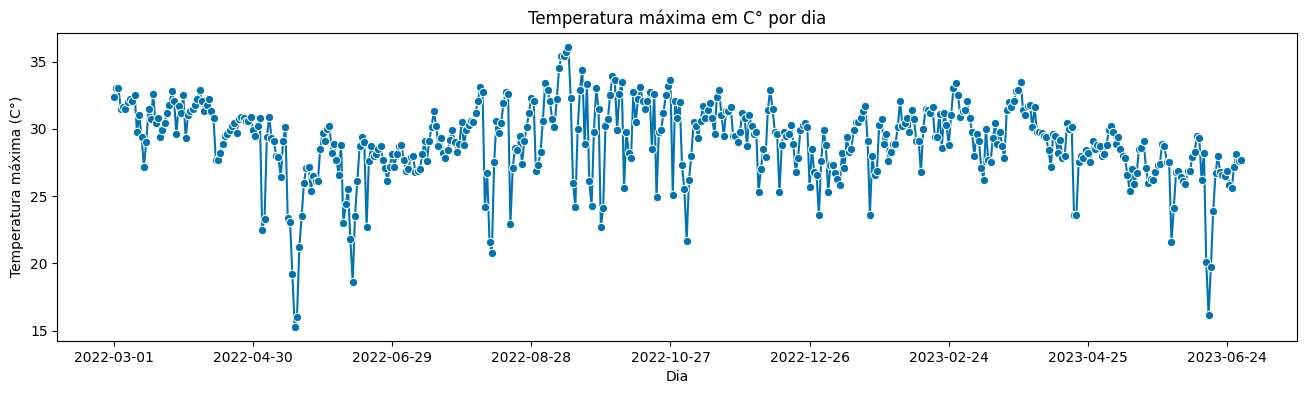

In [20]:
df = load_data()
df = preprocessing_date(df, "D", "Data")
y = df['Temp_Max_C']

plot_series(y)
plt.title("Temperatura máxima em C° por dia")
plt.ylabel("Temperatura máxima (C°)")
plt.xlabel("Dia")
plt.show()

C:\Users\leandro\Downloads\cd2023\cd2023\env\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


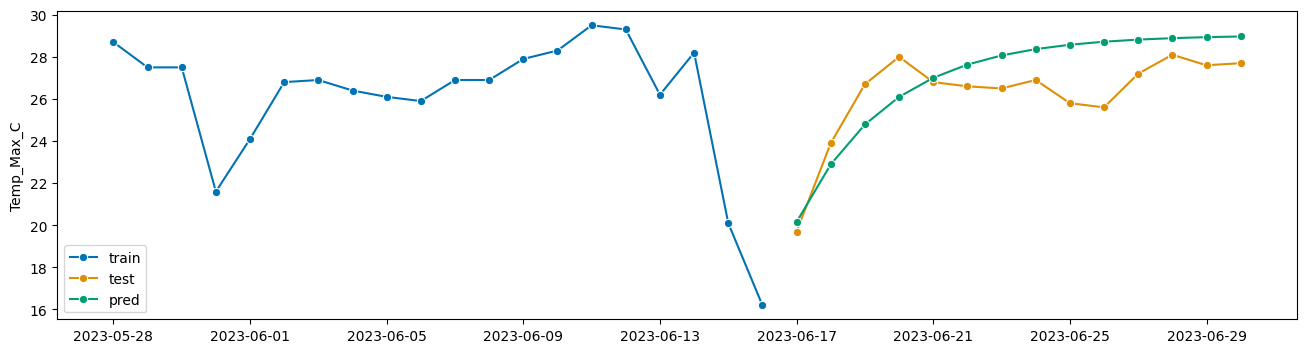

CPU times: total: 219 ms
Wall time: 1.13 s


,EVS,MAE,MAPE,RMSE
0,0.677286,1.46123,0.053455,1.653787


In [21]:
%%time
pipe = ForecastingPipeline(steps=[
    AutoARIMA()
])

y_train, y_test = temporal_train_test_split(
    y, test_size=14)

pipe_fit = pipe.fit(y_train)
y_pred = pipe_fit.predict(y_test.index)

plot_series(
    y_train[-20:], y_test, y_pred, 
    labels=['train', 'test', 'pred'])
plt.show()
compute_errors(y_pred, y_test)

<b>Problema:</b> Supondo que temos estimativas confiáveis de Radiação, Chuva e Umidade máxima, podemos melhorar os resultados?

C:\Users\leandro\Downloads\cd2023\cd2023\env\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\leandro\Downloads\cd2023\cd2023\env\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\leandro\Downloads\cd2023\cd2023\env\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\leandro\Downloads\cd2023\cd2023\env\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\leandro\Dow

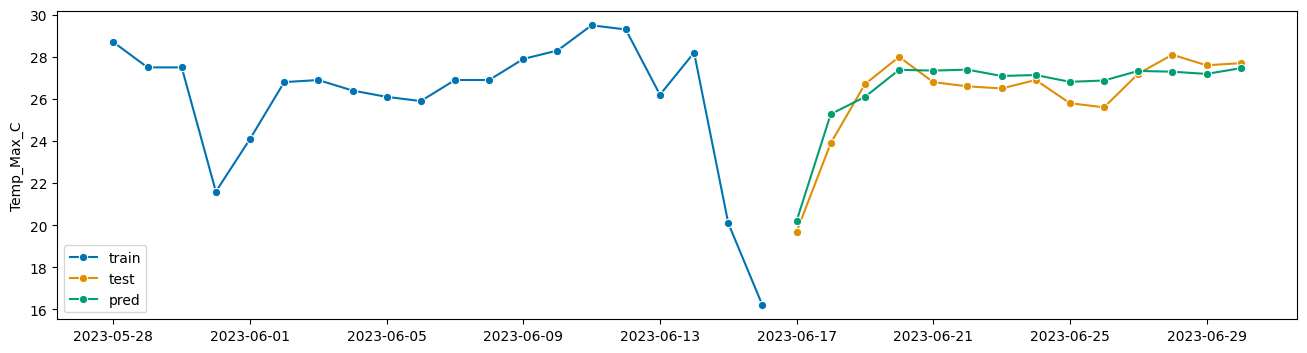

CPU times: total: 1.61 s
Wall time: 7.32 s


,EVS,MAE,MAPE,RMSE
0,0.857164,0.653641,0.024872,0.745713


In [23]:
%%time
X = df[[
    "Radiacao_KJ_por_m2", 
    "Chuva_mm", 
    "Umi_Max_percent"]]

pipe = ForecastingPipeline(steps=[
    ('detrend', Detrender()),
    ('deseason', Deseasonalizer()),
    ('auto_arima', AutoARIMA())
])

# forescat horizon
fh = ForecastingHorizon(
    pd.PeriodIndex(
        pd.date_range('2023-06-17', periods=14, freq="D")
    ),
    is_relative=False)

# train test split
y_train, y_test, X_train, X_test = temporal_train_test_split(
    y, X, fh=fh
)

pipe_fit = pipe.fit(y_train, X_train)
y_pred = pipe_fit.predict(fh=fh, X=X_test)

plot_series(
    y_train[-20:], y_test, y_pred, 
    labels=['train', 'test', 'pred'])
plt.show()
compute_errors(y_pred, y_test)

# Atividade avaliativa

Obter o melhor score possível em https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales

- <b>Meta 10:</b> 0.91868
- <b>Meta 07:</b> 1.02274
- <b>Meta 04:</b> 1.18099
- <b>Meta 00:</b> >= 2 

Outros valores serão proporcionais.

Data de entrega: 17/07/2023